# Image classification

kaggle
(https://www.kaggle.com/c/dog-breed-identification)

choose 120 types of dog for training

## fine-tuning
In the case of limited training data, the simplest migration learning technique called fine-tuning is used in order to quickly build a neural network with significant effects (faster convergence) on one's own dataset. fine-tuning refers to initializing a model that has already been trained on a large dataset (e.g., imagenet) (e.g., the used xception) as the basis for initializing the model, and iterating and weight tuning using data from the current scene.

The approximate steps are as follows.

Load the pre-trained model and adjust the network according to the scenario

First, we fine-tune the last layer of the Softmax classifier. The original network was designed to classify 1000 categories of objects, but now the data has only 120 category labels, so the number of neurons in the last output layer (FC8) becomes 120. A small learning rate is used to learn the weight matrix between layers FC7 and FC8, while fixing the weights of all layers up to this point.

Gradually expanding the range of fine-tuning

Extending the fine-tuning to more convolutional layers. The features extracted from the first convolutional layer are more primitive and general, while the second convolutional layer and the fully-connected layer are more relevant to the dataset, so sometimes the first few convolutional layers are not fine-tuned.




## Import packets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm   # import progress bar packet
from os import listdir, makedirs
from os.path import join

## Set parameters

  set epoch and batch size hyper parameters
  choose GPU or CPU for training


In [2]:
# Hyperparams if GPU is available
if tf.config.list_physical_devices('GPU'):
    # GPU
    BATCH_SIZE = 16  # Number of images used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1

## Preapare data

120 types of dogs are retained and can be adjusted by fixing **NUM_CLASSES**.

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/CV project/1.cv1-Image classification models by tensorflow+keras/dog-breed-identification"

os.chdir(path)
os.listdir(path)


Mounted at /content/drive


['sample_submission.csv', 'labels.csv', 'test', 'train', 'models']

In [4]:
# Retain 120 types of dogs
NUM_CLASSES = 120

data_dir = '/content/drive/MyDrive/Colab Notebooks/CV project/1.cv1-Image classification models by tensorflow+keras/dog-breed-identification' 
labels = pd.read_csv(join(data_dir, 'labels.csv')) 
# print(labels.sample(5))

print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train'))))) 

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of images in the dataset: 10222
Top 120 labels (sorted by number of samples)


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


### Migration Learning and Data Augmentation

Neural networks are very strong learning models, and the processing that helps a lot in image recognition results is called "data enhancement".

By data augmentation, we mean the transformation of an image in the form of **rotation**, **translation**, **scaling**, **horizontal flip**, **vertical flip**, etc. After the transformation, the computer accepts a completely different representation of the sample pixels, but these operations do not change the original image content, which is equivalent to the expansion and increment of the image, allowing the neural network to learn better.

This is usually done in keras using the parameters set in **ImageDataGenerator**.

In [5]:
import numpy as np
import requests

from os.path import join
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.applications import xception

from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def split_train_val(labels, num_classes, seed=1234):
    selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
    labels = labels.loc[labels['breed'].isin(selected_breed_list)].reset_index()
    labels['target'] = 1
    labels['rank'] = labels.groupby('breed').rank()['index']
    # labels['rank'] = labels['id']
    labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
    np.random.seed(seed=seed)
    rnd = np.random.random(len(labels))
    train_idx = rnd < 0.8   # 80% as training data
    valid_idx = rnd >= 0.8    # 20% as val data
    y_train = labels_pivot[selected_breed_list].values
    ytr = y_train[train_idx]    # Slice
    yv = y_train[valid_idx]
    return (train_idx, valid_idx, ytr, yv, labels, selected_breed_list)


def read_img(img_id, data_dir, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = cv2.imread(join(data_dir, train_or_test, '%s.jpg' % img_id))    # cv2.imread
    img = cv2.resize(img, size)
    # img = image.img_to_array(img)
    return img


def show_images(num_classes, labels, data_dir):
    j = int(np.sqrt(num_classes))
    i = int(np.ceil(1. * num_classes / j))
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
    for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
        ax = grid[i]
        img = read_img(img_id, data_dir, 'train', (224, 224))
        ax.imshow(img / 255.)
        ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
        ax.axis('off')
    plt.show()

def data_augmentation_example(input_path, count):
    # load image to array
    image = img_to_array(load_img(input_path))

    # reshape to array rank 4
    image = image.reshape((1,) + image.shape)

    # let's create infinite flow of images
    train_datagen = ImageDataGenerator(rotation_range=45,   # Rotatipm 45 angle
                                   width_shift_range=0.2,  # Horizontal translation
                                   height_shift_range=0.2, # Vertical translation
                                   shear_range=0.2,    #  Sharpen
                                   zoom_range=0.25,   # Zoom
                                   horizontal_flip=True,    # Horizontal mirror flip
                                   fill_mode='nearest')   
    images_flow = train_datagen.flow(image, batch_size=1)   # Traverse images

    plt.figure(figsize=(9,9))
    for idx, new_images in enumerate(images_flow):
        if idx < count:
            plt.subplot(330 + 1 + idx)
            new_image = array_to_img(new_images[0], scale=True)
            plt.imshow(new_image)
            plt.axis('off')
        else:
            plt.show()
            break
    
def prediction_from_url(url, model, selected_breed_list):
    test_image_path = '/tmp/test.jpg'
    response = requests.get(url)
    if response.status_code == 200:
        with open(test_image_path, 'wb') as f:
            f.write(response.content)
    img = read_img('test', '/', 'tmp', (224, 224))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    pred_idx = np.argmax(preds, axis=1)[0]
    plt.title('Prediction: %s (%.2f)' % (selected_breed_list[pred_idx] , preds[0][pred_idx]*100))
    plt.imshow(img / 255.)
    plt.axis('off')
    plt.show()        
    


def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):   # Confusion matrix, output heat map n*n matrix
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

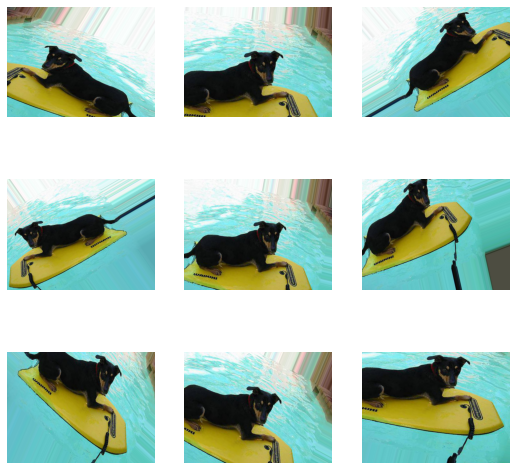

In [6]:
# Perform ImageDataGenerator on an image and visualize it

input_path = './train/01d0f3692e576b3cde511285352aed4a.jpg' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)

## Split training data and val data


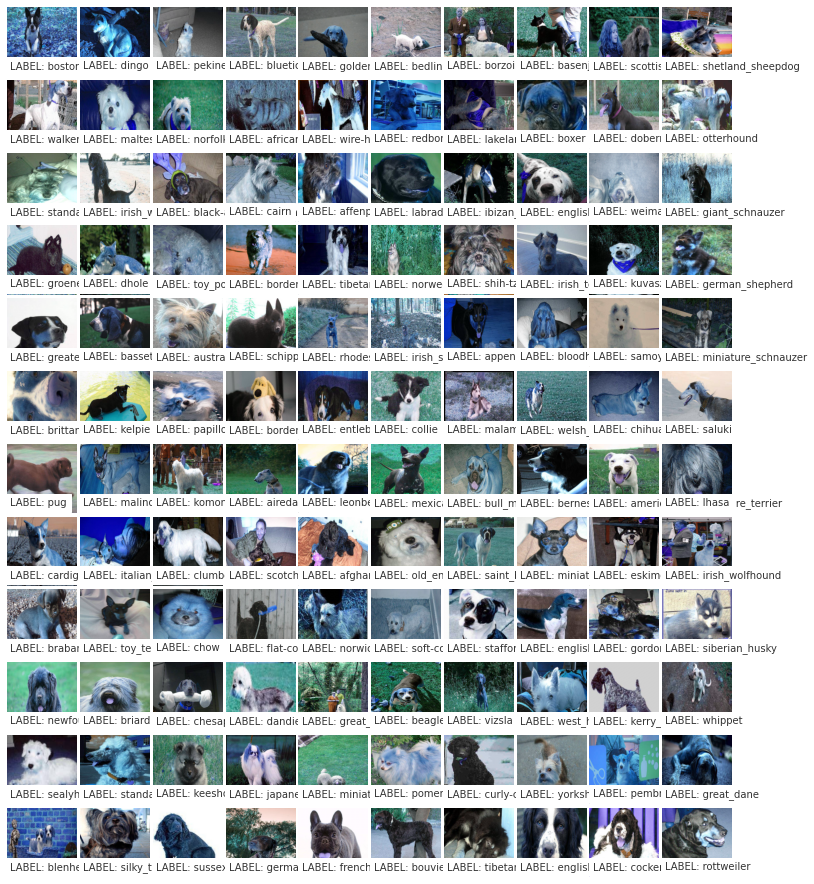

In [7]:
# Split train data and val data

SEED = 2019

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image

show_images(NUM_CLASSES, labels, data_dir)    # show labels images

## Data pre-processing

Before sending the image to the model for training, the image is preprocessed (e.g., operations such as resize and de-meaning) to process it into a dimension and shape that is acceptable to the model.

This is done through the pre-trained model interface of keras, e.g. using the xception.preprocess_input function to preprocess the image, and the image data enhancement is done through the class ImageDataGenerator.

In [8]:
# DATA LOADER
from keras.applications import xception   # import xception processing_input

INPUT_SIZE = 299 # width/height of image in pixels (as expected by Xception model)

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x   # Store image array in x_train list
print('\nTotal Images shape: {}'.format(x_train.shape))

Xtr = x_train[train_idx]    # Split train data
Xv = x_train[valid_idx]   # Split val data
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)

# Data Loader
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

10222it [1:55:31,  1.47it/s]



Total Images shape: (10222, 299, 299, 3)
Train (images, H, W, C): (8163, 299, 299, 3) 
Val (images, H, W, C): (2059, 299, 299, 3) 

Train samples (images, labels) (8163, 120) 
Validation samples (images, labels) (2059, 120)


## Load model

The current problem is solved using a pre-trained [Xception] model, the structure of which is shown below.

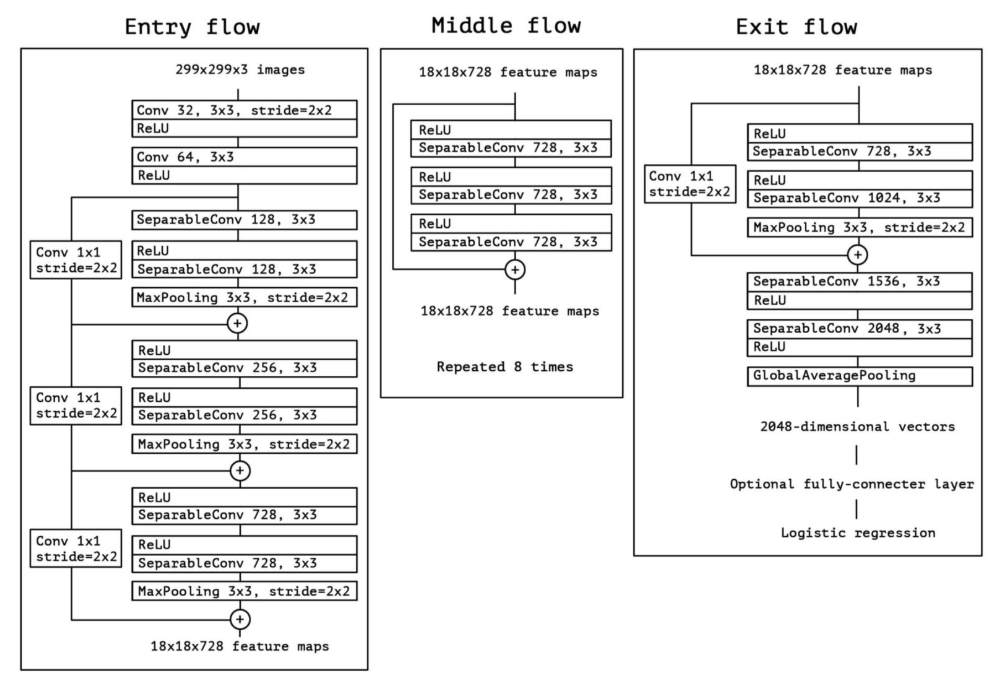

In [9]:
# import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model, Input

# Load the pre-trained xception model, notice that include_top=False means there is no 1000 softmax layers
base_model = xception.Xception(weights='imagenet', include_top=False)

# Add a few layers to the base model
x = base_model.output
# BN layer
x = BatchNormalization()(x)
# Global average pooling
x = GlobalAveragePooling2D()(x)
# Add dropout layer to improve generalization
x = Dropout(0.5)(x)
# Add full connection to increase expressiveness
x = Dense(1024, activation='relu')(x)
# Dropout layer
x = Dropout(0.5)(x)
# Divided into 120 categories
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# define whole model with inputs and outputs
model = Model(inputs=base_model.input, outputs=predictions)

# Exclude previous layres from training, i.e. their weights will never be updated
for layer in base_model.layers:
    layer.trainable = False   

# Specify optimizer and loss function for compilation
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
# Output model structure
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Training Convolutional Neural Networks


In [10]:
# TRAINING
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/3
510/510 - 161s - loss: 2.1220 - accuracy: 0.4971 - val_loss: 0.6998 - val_accuracy: 0.7983 - 161s/epoch - 316ms/step
Epoch 2/3
510/510 - 142s - loss: 1.6524 - accuracy: 0.6142 - val_loss: 0.7608 - val_accuracy: 0.7964 - 142s/epoch - 278ms/step
Epoch 3/3
510/510 - 142s - loss: 1.5099 - accuracy: 0.6347 - val_loss: 0.7036 - val_accuracy: 0.8145 - 142s/epoch - 278ms/step


## Evaluation on the validation set


In [11]:
# Evaluation
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen, steps=len(yv)/BATCH_SIZE+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


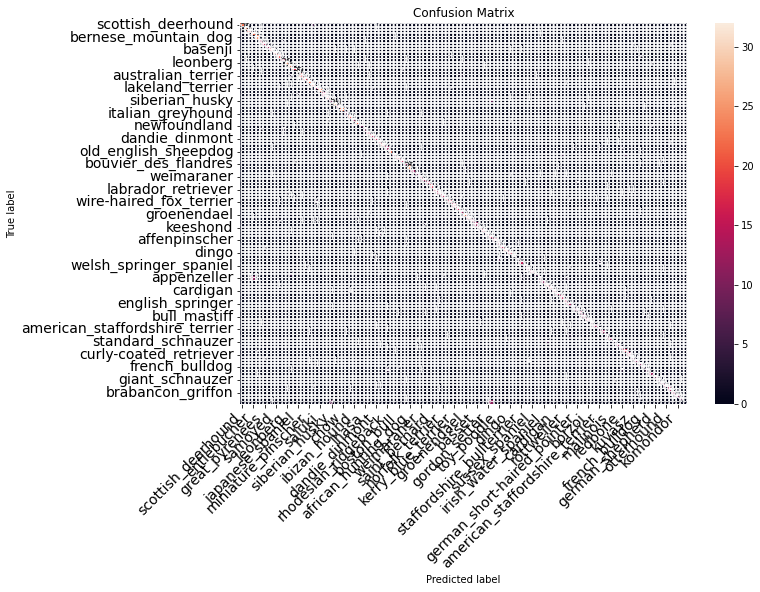

In [12]:
# Plotting multi-classification confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [13]:
# Print Precision-Recall and F1-Score
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

                                precision    recall  f1-score   support

            scottish_deerhound       0.81      1.00      0.90        22
                   maltese_dog       0.93      0.96      0.94        26
                  afghan_hound       1.00      1.00      1.00        20
                   entlebucher       0.96      0.63      0.76        35
          bernese_mountain_dog       0.96      0.85      0.90        27
                      shih-tzu       0.76      0.72      0.74        18
                great_pyrenees       0.75      0.79      0.77        19
                    pomeranian       1.00      0.92      0.96        13
                       basenji       0.75      0.82      0.78        22
                       samoyed       1.00      1.00      1.00        18
                      airedale       0.86      0.79      0.83        24
               tibetan_terrier       0.78      0.70      0.74        20
                      leonberg       0.89      0.81      0.85  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Interactive Forecasting

- Bernese: https://cdn.pixabay.com/photo/2016/02/06/19/18/dog-1183475_960_720.jpg
- Shih-tzu: https://cdn.pixabay.com/photo/2016/10/08/11/21/shih-tzu-puppy-1723492_960_720.jpg
- Samoyed: https://cdn.pixabay.com/photo/2017/06/14/00/59/samoyed-2400687_960_720.jpg

In [14]:
# Testing on url images
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(URL):
    prediction_from_url(URL, model, selected_breed_list)

interact_manual(get_prediction, URL=widgets.Text(placeholder='Insert URL with a dog pic'));

interactive(children=(Text(value='', description='URL', placeholder='Insert URL with a dog pic'), Button(descr…

## Store model


In [15]:
# Store the model weights obtained from training
!mkdir models
model.save_weights('models/tl_xception_weights.h5')

mkdir: cannot create directory ‘models’: File exists


## Summary


### 1. Data Analysis
- Balance of the sample: If the sample is not balanced, the assessment index cannot be used inaccuracy
- Treatment of imbalance
    - Data sampling (undersampling, oversampling)
        - 10:1 Sometimes we divide 10 into 10 parts and build models with 1 separately to get 10 models and do integration of model results
    - Sample Weighting
    - SMOTE data generation

### 2. Pre-training model fine-tune
- Data augmentation (available in both the training and test sets)

### 3. Model Integration
- Retraining
    - Select different models (inceptionV4/ResNet/DenseNet/NASNet)
    - Initialize the model with different initial values
- Single training session
    - Cyclical learning rate
        - https://github.com/mhmoodlan/cyclic-learning-rate
        - https://github.com/bckenstler/CLR
        